In [1]:
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install imblearn

In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = ['/Users/DELL/Desktop/demographic.csv',
        '/Users/DELL/Desktop/examination.csv',
        '/Users/DELL/Desktop/questionnaire.csv',
        '/Users/DELL/Desktop/labs.csv',
        '/Users/DELL/Desktop/diet.csv'
       ]
dfname = [
    'dm',
    'exam',
    'qs',
    'lab',
    'diet'
]
df = {}
dfn = dict(zip(dfname, path))
df = {key: pd.read_csv(value) for key, value in dfn.items()}

In [4]:
Xs = {k: v for k, v in df.items() if k in ['dm', 'exam', 'labs']}

dfs = Xs.values()

from functools import partial, reduce 
inner_merge = partial(pd.merge, how='inner', on='SEQN') 

c = reduce(inner_merge, dfs)
c

# check if there are duplicated SEQN
c.SEQN.duplicated().value_counts()


False    9813
Name: SEQN, dtype: int64

In [5]:
# show combined df
qs = df['qs'][['SEQN','DIQ010']]
qs


,SEQN,DIQ010
0,73557,1.0
1,73558,1.0
2,73559,1.0
3,73560,2.0
4,73561,2.0
...,...,...
10170,83727,2.0
10171,83728,2.0
10172,83729,2.0
10173,83730,2.0


In [6]:
c = pd.merge(c,qs, how='left', on='SEQN')
c.DIQ010.value_counts()

2.0    8514
1.0     722
3.0     179
9.0       5
7.0       1
Name: DIQ010, dtype: int64

In [7]:
# MCQ160F (target feature): exclude null values and NA
c = c[(c.DIQ010.notnull()) & (c.DIQ010 != 9)& (c.DIQ010 != 7) & (c.DIQ010 != 3)]
# check MCQ160F
c.DIQ010.describe()


count    9236.000000
mean        1.921828
std         0.268457
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: DIQ010, dtype: float64

In [8]:
# exclude non-numeric values
d = c.select_dtypes(['number'])

# exclue columns that have over 50% NaN
d = d.dropna(thresh = 0.5*len(d), axis =1)

print(len(d.columns), 'columns left')

126 columns left


In [9]:
# changing target variable coding from 1, 2 to 0 (Negative), 1 (Positive)
d['DIQ010']=d.apply(lambda x: 1 if x.DIQ010 == 1 else 0, axis='columns')
d.DIQ010.value_counts() 


0    8514
1     722
Name: DIQ010, dtype: int64

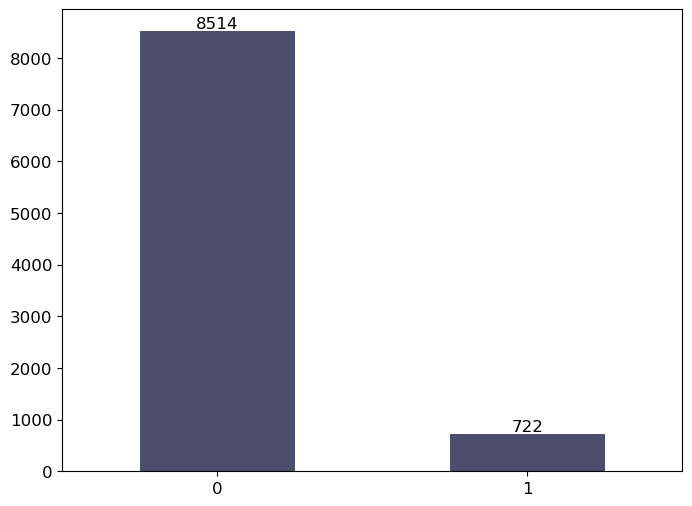

In [10]:
vals = d.DIQ010.value_counts()

plt.figure(figsize=(8,6))
plt.rc('font', size=12)

ax = vals.plot.bar(rot=0, color='#4B4E6D')

for i in range(len(vals)):
    ax.annotate(vals[i], xy=[vals.index[i], vals[i]], ha='center', va='bottom')

In [11]:
# replace NA with most frequent values
from sklearn.impute import SimpleImputer
imp_mode=SimpleImputer(strategy='most_frequent')

d = pd.DataFrame(imp_mode.fit_transform(d), columns=d.columns)
d 

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,...,OHX24TC,OHX25TC,OHX26TC,OHX27TC,OHX28TC,OHX29TC,OHX30TC,OHX31TC,OHX32TC,DIQ010
0,73557.0,8.0,2.0,1.0,69.0,4.0,4.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0
1,73558.0,8.0,2.0,1.0,54.0,3.0,3.0,1.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0,1.0
2,73559.0,8.0,2.0,1.0,72.0,3.0,3.0,2.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,4.0,1.0
3,73560.0,8.0,2.0,1.0,9.0,3.0,3.0,1.0,2.0,1.0,...,2.0,2.0,2.0,4.0,1.0,1.0,2.0,4.0,4.0,0.0
4,73561.0,8.0,2.0,2.0,73.0,3.0,3.0,1.0,2.0,1.0,...,4.0,2.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,83727.0,8.0,2.0,1.0,26.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,4.0,0.0
9232,83728.0,8.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,0.0
9233,83729.0,8.0,2.0,2.0,42.0,4.0,4.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,0.0
9234,83730.0,8.0,2.0,1.0,7.0,2.0,2.0,1.0,2.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,2.0,4.0,4.0,0.0


In [12]:
X = d.loc[:, d.columns != 'DIQ010']
y = d.DIQ010
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (9236, 125)
y shape: (9236,)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

def confusion(y_test, y_pred):
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf

confusion(y_test, y_pred) 


Accuracy: 91.61%
Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1671          38
True[1]         117          22


,Predict[0],Predict[1]
True[0],1671,38
True[1],117,22


In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

print(y_train_sm.value_counts())
print(y_test_sm.value_counts())

0.0    6805
1.0    6805
Name: DIQ010, dtype: int64
0.0    1709
1.0    1709
Name: DIQ010, dtype: int64


In [16]:
# After oversampling, the classification result is more reasonable.
model = XGBClassifier()
model.fit(X_train_sm, y_train_sm)
y_pred_sm = model.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred_sm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
conf = pd.DataFrame(confusion_matrix(y_test_sm, y_pred_sm), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
conf

Accuracy: 94.76%


,Predict[0],Predict[1]
True[0],1664,45
True[1],134,1575


Execution time: 00:00:06


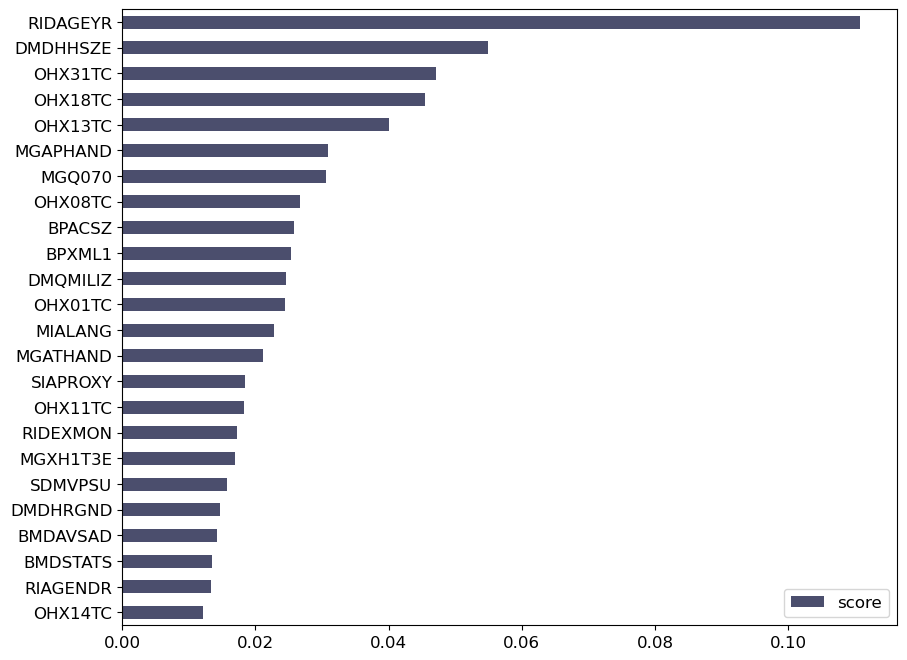

In [17]:
from xgboost import XGBClassifier
from matplotlib import pyplot
import time
st = time.time()
# fit model no training data
model = XGBClassifier()
model.fit(X_train_sm, y_train_sm)

# Features selected by XGBoost
keys = list(model.get_booster().feature_names)
values = list(model.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 24 features
xgbfs_ = data[:24]

# Plot feature score
xgbfs_.sort_values(by='score').plot(kind='barh', figsize=(10, 8), color='#4B4E6D')
time.sleep(3)
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [18]:
xgbfs = xgbfs_.reset_index()
xgbfs.columns=['variable', 'score']

xgbfs['variable'] = xgbfs['variable'].apply(lambda x: x.upper())

In [19]:
var_list = xgbfs.variable.tolist()
var_list.append('DIQ010')
print(var_list)

['RIDAGEYR', 'DMDHHSZE', 'OHX31TC', 'OHX18TC', 'OHX13TC', 'MGAPHAND', 'MGQ070', 'OHX08TC', 'BPACSZ', 'BPXML1', 'DMQMILIZ', 'OHX01TC', 'MIALANG', 'MGATHAND', 'SIAPROXY', 'OHX11TC', 'RIDEXMON', 'MGXH1T3E', 'SDMVPSU', 'DMDHRGND', 'BMDAVSAD', 'BMDSTATS', 'RIAGENDR', 'OHX14TC', 'DIQ010']


In [20]:
df_final = d.filter(var_list)
df_final

,RIDAGEYR,DMDHHSZE,OHX31TC,OHX18TC,OHX13TC,MGAPHAND,MGQ070,OHX08TC,BPACSZ,BPXML1,...,OHX11TC,RIDEXMON,MGXH1T3E,SDMVPSU,DMDHRGND,BMDAVSAD,BMDSTATS,RIAGENDR,OHX14TC,DIQ010
0,69.0,2.0,4.0,4.0,4.0,1.0,2.0,4.0,4.0,140.0,...,4.0,1.0,1.0,1.0,1.0,20.6,1.0,1.0,4.0,1.0
1,54.0,0.0,4.0,4.0,2.0,1.0,1.0,2.0,4.0,170.0,...,2.0,1.0,1.0,1.0,1.0,24.4,1.0,1.0,2.0,1.0
2,72.0,2.0,4.0,2.0,2.0,1.0,2.0,2.0,4.0,160.0,...,2.0,2.0,1.0,1.0,1.0,25.6,1.0,1.0,2.0,1.0
3,9.0,0.0,4.0,4.0,1.0,1.0,2.0,2.0,2.0,130.0,...,4.0,1.0,1.0,2.0,1.0,14.9,1.0,1.0,2.0,0.0
4,73.0,2.0,4.0,4.0,2.0,1.0,2.0,4.0,3.0,170.0,...,2.0,1.0,1.0,2.0,1.0,22.9,3.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,26.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,140.0,...,2.0,2.0,1.0,1.0,2.0,19.1,1.0,1.0,2.0,0.0
9232,2.0,0.0,4.0,4.0,4.0,2.0,2.0,1.0,4.0,140.0,...,1.0,2.0,1.0,1.0,1.0,22.9,1.0,2.0,4.0,0.0
9233,42.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,150.0,...,2.0,2.0,1.0,1.0,2.0,24.3,1.0,2.0,2.0,0.0
9234,7.0,0.0,4.0,4.0,1.0,2.0,2.0,2.0,4.0,140.0,...,1.0,1.0,1.0,2.0,2.0,22.9,1.0,1.0,2.0,0.0


<AxesSubplot:>

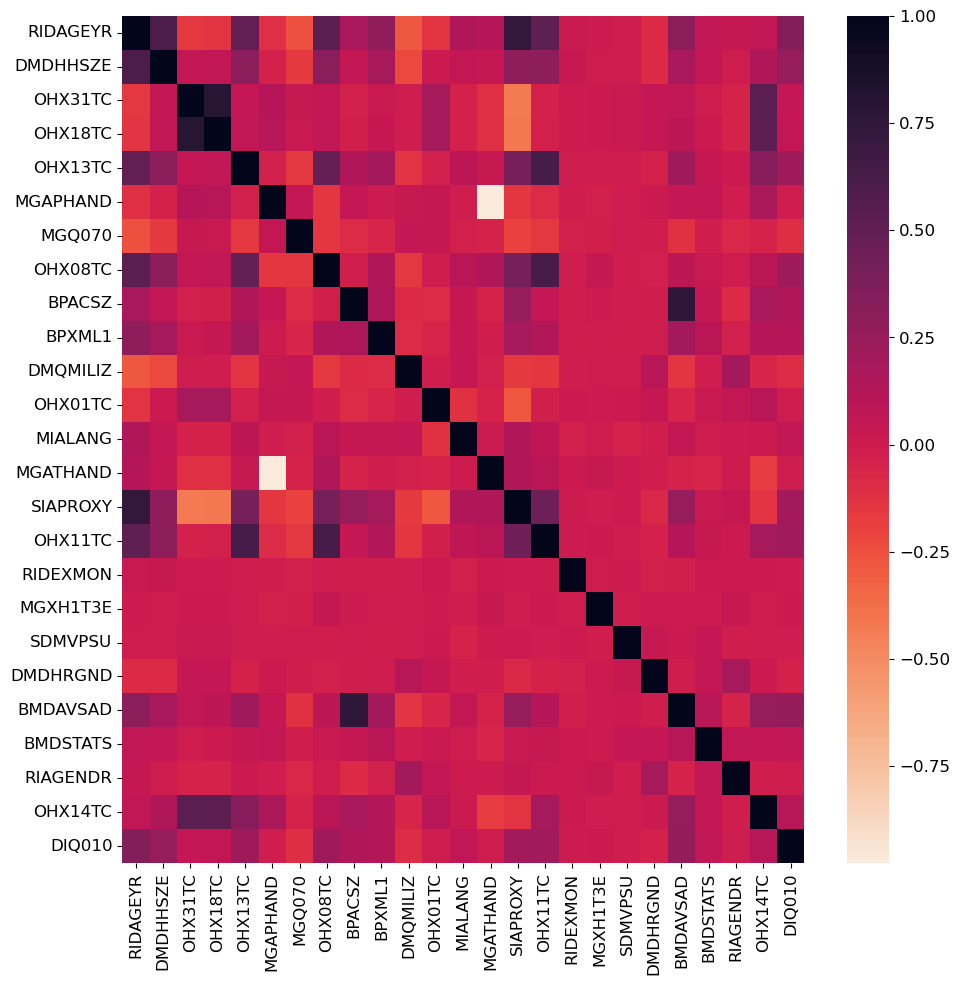

In [21]:
# sns.axes_style("white")
ax = plt.subplots(figsize=(11,11))

corr = df_final.corr()

#sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.cm.rocket_r)
sns.heatmap(corr, cmap=sns.cm.rocket_r)

In [22]:
X_ = df_final.loc[:, df_final.columns != 'DIQ010']
y = df_final.DIQ010

In [23]:
from sklearn.preprocessing import MinMaxScaler

minmax=MinMaxScaler()
X = pd.DataFrame(minmax.fit_transform(X_), columns=X_.columns)
X

,RIDAGEYR,DMDHHSZE,OHX31TC,OHX18TC,OHX13TC,MGAPHAND,MGQ070,OHX08TC,BPACSZ,BPXML1,...,SIAPROXY,OHX11TC,RIDEXMON,MGXH1T3E,SDMVPSU,DMDHRGND,BMDAVSAD,BMDSTATS,RIAGENDR,OHX14TC
0,0.860759,0.666667,0.666667,0.666667,0.75,0.0,0.125,0.75,0.75,0.050761,...,1.0,0.75,0.0,0.0,0.0,0.0,0.350000,0.000000,0.0,0.666667
1,0.670886,0.000000,0.666667,0.666667,0.25,0.0,0.000,0.25,0.75,0.088832,...,1.0,0.25,0.0,0.0,0.0,0.0,0.476667,0.000000,0.0,0.000000
2,0.898734,0.666667,0.666667,0.000000,0.25,0.0,0.125,0.25,0.75,0.076142,...,1.0,0.25,1.0,0.0,0.0,0.0,0.516667,0.000000,0.0,0.000000
3,0.101266,0.000000,0.666667,0.666667,0.00,0.0,0.125,0.25,0.25,0.038071,...,0.0,0.75,0.0,0.0,1.0,0.0,0.160000,0.000000,0.0,0.000000
4,0.911392,0.666667,0.666667,0.666667,0.25,0.0,0.125,0.75,0.50,0.088832,...,1.0,0.25,0.0,0.0,1.0,0.0,0.426667,0.666667,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,0.316456,0.000000,0.000000,0.000000,0.25,0.0,0.125,0.25,0.50,0.050761,...,1.0,0.25,1.0,0.0,0.0,1.0,0.300000,0.000000,0.0,0.000000
9232,0.012658,0.000000,0.666667,0.666667,0.75,1.0,0.125,0.00,0.75,0.050761,...,0.0,0.00,1.0,0.0,0.0,0.0,0.426667,0.000000,1.0,0.666667
9233,0.518987,0.000000,0.000000,0.000000,0.25,1.0,0.125,0.25,0.75,0.063452,...,1.0,0.25,1.0,0.0,0.0,1.0,0.473333,0.000000,1.0,0.000000
9234,0.075949,0.000000,0.666667,0.666667,0.00,1.0,0.125,0.25,0.75,0.050761,...,0.0,0.00,0.0,0.0,1.0,1.0,0.426667,0.000000,0.0,0.000000


In [24]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
# X_test_sm, y_test_sm = smote.fit_sample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
# X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

In [26]:
print('X train shape: ',X_train_sm.shape)
print('y train values: \n', y_train_sm.value_counts())
print()
print('X test shape: ',X_test.shape)
print('y test values: \n', y_test.value_counts())

X train shape:  (12796, 24)
y train values: 
 0.0    6398
1.0    6398
Name: DIQ010, dtype: int64

X test shape:  (2309, 24)
y test values: 
 0.0    2116
1.0     193
Name: DIQ010, dtype: int64


In [27]:
mscore=[]

In [28]:
from sklearn.linear_model import LogisticRegression
import time

st = time.time()
clf = LogisticRegression(max_iter=100, solver='lbfgs', class_weight='balanced', random_state=11)
tic = time.time()
clf.fit(X_train_sm, y_train_sm)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

y_pred = clf.predict(X_test)
print('Accuracy Score:', clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Logistic Regression', clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Time: 93.74761581420898ms
Execution time: 00:00:00
Accuracy Score: 0.7721957557384149
Prediction: [0. 0. 1. ... 1. 1. 0.]
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      2116
         1.0       0.25      0.83      0.38       193

    accuracy                           0.77      2309
   macro avg       0.61      0.80      0.62      2309
weighted avg       0.92      0.77      0.82      2309

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1623         493
True[1]          33         160


,Predict[0],Predict[1]
True[0],1623,493
True[1],33,160


In [29]:
from sklearn.ensemble import RandomForestClassifier
import time

st = time.time()
rnd_clf = RandomForestClassifier(n_estimators=150, criterion='gini', max_depth=5, random_state=11)
tic = time.time()
model = rnd_clf.fit(X_train_sm, y_train_sm)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

y_pred = rnd_clf.predict(X_test)

print('Accuracy Score:', rnd_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Random Forest', rnd_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)
print(pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

Time: 856.7075729370117ms
Execution time: 00:00:00
Accuracy Score: 0.8046773495019489
Prediction: [0. 0. 0. ... 1. 1. 0.]
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88      2116
         1.0       0.27      0.76      0.39       193

    accuracy                           0.80      2309
   macro avg       0.62      0.79      0.64      2309
weighted avg       0.91      0.80      0.84      2309

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1711         405
True[1]          46         147
    Variable  Importance
0   RIDAGEYR    0.250514
1   DMDHHSZE    0.198775
9     BPXML1    0.127264
20  BMDAVSAD    0.090511
14  SIAPROXY    0.080893
8     BPACSZ    0.060956
4    OHX13TC    0.058814
15   OHX11TC    0.023607
6     MGQ070    0.022349
7    OHX08TC    0.018949
2    OHX31TC    0.014721
10  DMQMILIZ    0.014641
21  BMDSTATS    0.010150
23   OHX14TC    0.007702
3    OHX18TC    0.006989
11   OHX01TC    0.006736
19  DMDHRGND

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
import time

st = time.time()
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, random_state=11)
tic = time.time()
gbc.fit(X_train_sm, y_train_sm)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")
#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

y_pred = gbc.predict(X_test)

print('Accuracy Score:', gbc.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['GradientBoosting', gbc.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Time: 214.46561813354492ms
Execution time: 00:00:00
Accuracy Score: 0.776093546990039
Prediction: [0. 0. 1. ... 1. 0. 0.]
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      2116
         1.0       0.25      0.84      0.39       193

    accuracy                           0.78      2309
   macro avg       0.62      0.81      0.62      2309
weighted avg       0.92      0.78      0.82      2309

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1629         487
True[1]          30         163


,Predict[0],Predict[1]
True[0],1629,487
True[1],30,163


In [31]:
from sklearn.ensemble import AdaBoostClassifier
import time

st = time.time()
ada = AdaBoostClassifier(learning_rate=0.01, n_estimators=30, random_state=11)
tic = time.time()
ada.fit(X_train_sm, y_train_sm)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")
#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

y_pred = ada.predict(X_test)

print('Accuracy Score:', ada.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Adaptive Boosting', ada.score(X_test, y_test)])

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Time: 368.01600456237793ms
Execution time: 00:00:00
Accuracy Score: 0.6977046340407103
Prediction: [0. 0. 1. ... 1. 1. 0.]
              precision    recall  f1-score   support

         0.0       0.99      0.68      0.80      2116
         1.0       0.20      0.90      0.33       193

    accuracy                           0.70      2309
   macro avg       0.60      0.79      0.57      2309
weighted avg       0.92      0.70      0.77      2309

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1437         679
True[1]          19         174


,Predict[0],Predict[1]
True[0],1437,679
True[1],19,174


In [32]:
from sklearn.svm import SVC
import time

st = time.time()
svm_clf = SVC(kernel='sigmoid', gamma='auto', random_state=11)
tic = time.time()
svm_clf.fit(X_train_sm, y_train_sm)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

y_pred = svm_clf.predict(X_test)

print('Accuracy Score:', svm_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['SVM', svm_clf.score(X_test, y_test)])

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Time: 4982.6719760894775ms
Execution time: 00:00:04
Accuracy Score: 0.7514075357297532
Prediction: [0. 0. 1. ... 1. 1. 0.]
              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85      2116
         1.0       0.23      0.87      0.37       193

    accuracy                           0.75      2309
   macro avg       0.61      0.80      0.61      2309
weighted avg       0.92      0.75      0.81      2309

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1568         548
True[1]          26         167


,Predict[0],Predict[1]
True[0],1568,548
True[1],26,167


In [33]:
from xgboost import XGBClassifier
import time

st = time.time()
xgbc = XGBClassifier(eta=0.01, max_depth=3, random_state=11)
# xgbc = XGBClassifier(eta=0.01)
tic = time.time()
xgbc.fit(X_train_sm, y_train_sm)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

y_pred = xgbc.predict(X_test)

print('Accuracy Score:', xgbc.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['XGBoost', xgbc.score(X_test, y_test)])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Time: 498.66318702697754ms
Execution time: 00:00:00
Accuracy Score: 0.7592031182330014
Prediction: [0 0 1 ... 1 1 0]
              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85      2116
         1.0       0.24      0.84      0.37       193

    accuracy                           0.76      2309
   macro avg       0.61      0.80      0.61      2309
weighted avg       0.92      0.76      0.81      2309

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1591         525
True[1]          31         162


,Predict[0],Predict[1]
True[0],1591,525
True[1],31,162


In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

st = time.time()
bagging = BaggingClassifier(base_estimator= KNeighborsClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False, random_state=11)
tic = time.time()
bagging.fit(X_train_sm, y_train_sm)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")
#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

bg_pred_diabetes = bagging.predict(X_test)

bg_score = bagging.score(X_test, y_test)
bagging.score(X_test, y_test)

mscore.append(['Bagging_KNeighbors', bagging.score(X_test, y_test)])

Time: 162.5649929046631ms
Execution time: 00:00:00


In [59]:
from sklearn.neural_network import MLPClassifier
import time

st = time.time()
mlp = MLPClassifier(hidden_layer_sizes=([100,100]), solver='adam', shuffle=False, tol = 0.0001, random_state=11)

tic = time.time()
mlp.fit(X_train_sm, y_train_sm)
toc = time.time()
print("Time" + str(1000*(toc-tic)) + "ms")


#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

mlp_pred_diabetes = mlp.predict(X_test)
print('Accuracy Score:', mlp.score(X_test, y_test))
print('Prediction:', mlp_pred_diabetes)
print("parameter: ", mlp.get_params())

mscore.append(['MLP', mlp.score(X_test, y_test)])

Time21122.235774993896ms
Execution time: 00:00:21
Accuracy Score: 0.81203984408835
Prediction: [0. 1. 0. ... 1. 1. 0.]
parameter:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': [100, 100], 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 11, 'shuffle': False, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [58]:
from sklearn.tree import DecisionTreeClassifier
import time

st = time.time()
bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False, random_state=11)
tic = time.time()
bagging.fit(X_train_sm, y_train_sm)
toc = time.time()
print("good" + str(1000*(toc-tic)) + "ms")

#time.sleep(3)
elapsed_time = time.time() - st
# print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

bg_pred_diabetes = bagging.predict(X_test)

bg_dt_score = bagging.score(X_test, y_test)
bagging.score(X_test, y_test)

mscore.append(['Bagging_Decision Tree based', bagging.score(X_test, y_test)])

good213.42754364013672ms
Execution time: 00:00:00


In [37]:
mscore.sort(key=lambda x: x[1], reverse=True)
mscore

[['Bagging_Decision Tree based', 0.8960588999566912],
 ['Bagging_KNeighbors', 0.8345604157644002],
 ['Random Forest', 0.8046773495019489],
 ['GradientBoosting', 0.776093546990039],
 ['Logistic Regression', 0.7721957557384149],
 ['XGBoost', 0.7592031182330014],
 ['SVM', 0.7514075357297532],
 ['Adaptive Boosting', 0.6977046340407103],
 ['MLP', 0.4235599826764833]]

Accracy Score: 

Bagging_Decision Tree based: 89.61%
Bagging_KNeighbors: 83.46%
Random Forest: 80.47%
GradientBoosting: 77.61%
Logistic Regression: 77.22%
XGBoost: 75.92%
SVM: 75.14%
Adaptive Boosting: 69.77%
MLP: 42.36%
MLP: 76.14%
Bagging_Decision Tree based: 89.61%
MLP: 42.36%
MLP: 74.36%
MLP: 81.2%


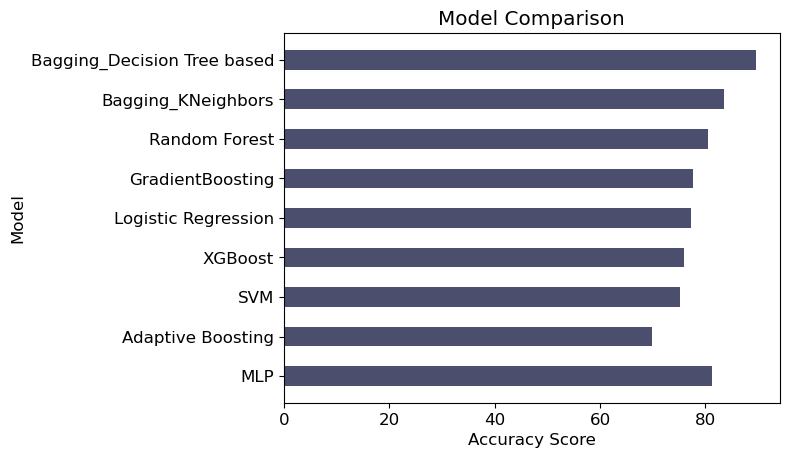

In [53]:
model = list(i[0] for i in mscore)
score = list(round(i[1]*100,2) for i in mscore)

print('Accracy Score: \n')
for m,s in zip(model, score):
    print(f'{m}: {s}%')
  
 
# creating horizontal bar plot
plt.barh(model, score, height = 0.5, color='#4B4E6D') # this color is called independence, how cool!
 
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.title("Model Comparison")
plt.gca().invert_yaxis()
plt.show()